# Image Compression: JPEG

In [1]:
# Run in Virtual Environment for compatibility issues
import cv2
import math
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

from huffman import HuffmanEncoder

(853, 1280, 3)


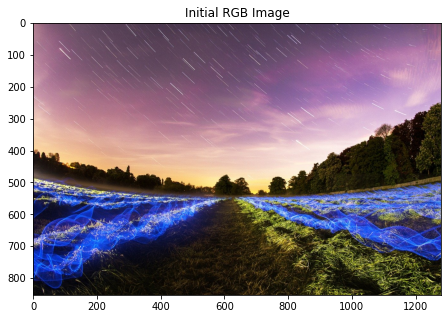

In [2]:
# Load image
img_directory = "photo1.png"
img_rgb = Image.open(img_directory).convert('RGB')      # Convert to RGB (remove alpha dimention)
img_rgb_matrix = np.array(img_rgb)                      # Convert to RGB matrix

print(img_rgb_matrix.shape)

# Show image
plt.figure(figsize = (10, 5))
plt.imshow(img_rgb_matrix)
plt.title('Initial RGB Image')
plt.show()

## 1) RGB-to-YCbCr & Sambling

### 1.1) RGB-to-YCbCr

In [3]:
def rgb_to_ycbcr(im):
    ''' Convert RGB image to YCbCr '''

    # Coefficients
    coefs = [[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]]

    # Convert to YCbCr
    ycbcr = im.dot(np.array(coefs).T)

    # Shift 128 pixels to the center of the range
    ycbcr[:,:,[1,2]] += 128

    # Return as unsigned 8-bit integers
    return np.uint8(ycbcr)


def ycbcr_to_rgb(im):
    ''' Convert YCbCr image to RGB '''

    # Coefficients
    coefs = [[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]]

    xform = np.array(coefs)
    rgb = im.astype(np.float)

    # Shift back to the range [0, 255]
    rgb[:,:,[1,2]] -= 128

    # Convert to RGB
    rgb = rgb.dot(xform.T)

    # Clip to [0, 255]
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)

    # Return as unsigned 8-bit integers
    return np.uint8(rgb)

(853, 1280, 3)


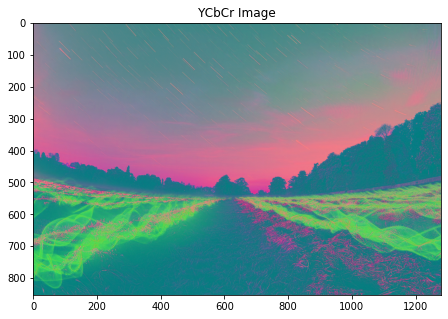

In [4]:
# Convert to YCbCr
img_ycbcr = rgb_to_ycbcr(img_rgb_matrix)

print(img_rgb_matrix.shape)

# Show image
plt.figure(figsize = (10, 5))
plt.imshow(img_ycbcr)
plt.title('YCbCr Image')
plt.show()

In [5]:
# # The following cell converts RGB to YCbCr using the OpenCV library.
# # Run it to ensure conversion is correct.
# imgYCC = cv2.cvtColor(img_rgb_matrix, cv2.COLOR_BGR2YCR_CB)

# # Show image
# plt.figure(figsize = (10, 5))
# plt.imshow(imgYCC)
# plt.title('YCbCr Image')
# plt.show()

### 2.2) Chroma Subsampling

In [6]:
# Sample ration
SSV = 2
SSH = 2

# Make shape even
img_ycbcr = img_ycbcr[1:, :, :]
img_ycbcr.shape

(852, 1280, 3)

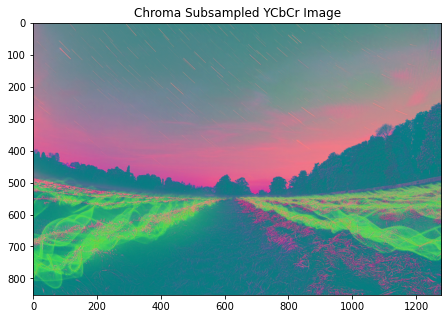

In [7]:
# Make a copy to avoid changing the original image
img_ycbcr_sampled = img_ycbcr.copy()

for i in [1, 2]:

    # 4:2:0
    img_ycbcr_sampled[1::SSV, :, i] = img_ycbcr_sampled[::SSV, :, i]  # Vertically, every second element equals to element above itself
    img_ycbcr_sampled[:, 1::SSH, i] = img_ycbcr_sampled[:, ::SSH, i]  # Horizontally, every second element equals to the element on its left side


# Show image
plt.figure(figsize = (10, 5))
plt.imshow(img_ycbcr_sampled)
plt.title('Chroma Subsampled YCbCr Image')
plt.show()

## 2) Blocking & DCT

### 2.1) Blocking

In [8]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """

    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return (arr.reshape(h // nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))


def fix_dimensions(x, block_size):
    """ Fixes the dimentions to be dividable by 'block_size' """

    # Rows
    rows = np.zeros(((math.ceil(x.shape[0] / block_size) * block_size) - x.shape[0], x.shape[1], x.shape[2]))
    x = np.append(x, rows, axis = 0)

    # Columns
    cols = np.zeros((x.shape[0], (math.ceil(x.shape[1] / block_size) * block_size) - x.shape[1], x.shape[2]))
    x = np.append(x, cols, axis = 1)
    
    return x

In [9]:
block_size = 8

# Fix rows and columns to be devidable by "block_size"
img_ycbcr_sampled_fixed = fix_dimensions(img_ycbcr_sampled, block_size)
print(img_ycbcr_sampled_fixed.shape)

# Convert to list of 8x8 blocks
temp = [blockshaped(img_ycbcr_sampled_fixed[:, :, i], block_size, block_size).tolist() for i in [0, 1, 2]]

# Add third dimention - list of 3x8x8 blocks
img_ycbcr_sampled_fixed_blocks = [np.array((temp[0][i], temp[1][i], temp[2][i])) for i in range(len(temp[0]))]
print(f'{len(img_ycbcr_sampled_fixed_blocks)} of {img_ycbcr_sampled_fixed_blocks[0].shape} blocks')

(856, 1280, 3)
17120 of (3, 8, 8) blocks


### 2.2) DCT

In [10]:
print('before:', img_ycbcr_sampled_fixed_blocks[0][0, :, :], sep = '\n')

# Apply DCT
img_ycbcr_sampled_fixed_blocks_dct = img_ycbcr_sampled_fixed_blocks.copy()
for i in range(len(img_ycbcr_sampled_fixed_blocks)):
    for j in [0, 1, 2]:
        img_ycbcr_sampled_fixed_blocks_dct[i][j, :, :] = cv2.dct(img_ycbcr_sampled_fixed_blocks[i][j, :, :])

print('\nacter:', img_ycbcr_sampled_fixed_blocks_dct[0][0, :, :], sep = '\n')

before:
[[139. 141. 150. 146. 149. 138. 136. 131.]
 [149. 143. 146. 139. 141. 132. 139. 144.]
 [147. 142. 149. 147. 148. 133. 136. 141.]
 [148. 142. 146. 144. 146. 133. 139. 145.]
 [153. 143. 142. 134. 139. 135. 146. 152.]
 [143. 142. 148. 144. 151. 143. 142. 136.]
 [152. 148. 148. 138. 145. 141. 142. 134.]
 [151. 148. 145. 147. 144. 134. 149. 134.]]

acter:
[[ 1.14275000e+03  2.17296985e+01  5.24781576e-01 -3.51597266e+00
   7.50000000e+00  2.31997602e+00 -2.65275410e+00  1.69322429e+01]
 [-6.64288497e+00 -9.78589145e-01 -5.04521195e+00 -8.29910728e+00
   6.11708888e+00 -3.74744336e+00  5.00868351e+00  2.12354371e-01]
 [-1.56074649e+00  7.46357763e+00 -1.06694174e+01  3.04882590e+00
  -7.00155371e+00  3.34472454e+00 -4.32627163e+00 -5.08740284e-01]
 [-1.57785482e+00 -4.73782796e+00 -4.52979843e+00  4.60269772e+00
  -6.03466082e+00 -3.28816590e+00  4.09973039e+00  5.53036010e-01]
 [-5.00000000e-01 -2.53438717e+00  3.62306091e+00 -1.77054076e+00
   1.25000000e+00  2.89740860e+00 -3.6655

### 3) Quantization

In [11]:
QY = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,48,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]]
)

QC = np.array([
    [17,18,24,47,99,99,99,99],
    [18,21,26,66,99,99,99,99],
    [24,26,56,99,99,99,99,99],
    [47,66,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99]]
)

# 1 for Luminance, 2 for Chromas
Q = [QY, QC, QC]

In [12]:
img_ycbcr_sampled_fixed_blocks_dct_quantized = img_ycbcr_sampled_fixed_blocks_dct.copy()
for i in range(len(img_ycbcr_sampled_fixed_blocks_dct)):
    for j in [0, 1, 2]:
        img_ycbcr_sampled_fixed_blocks_dct_quantized[i][j, :, :] = img_ycbcr_sampled_fixed_blocks_dct[i][j, :, :] // Q[j]

In [13]:
img_ycbcr_sampled_fixed_blocks_dct_quantized[0][0, :]

array([[71.,  1.,  0., -1.,  0.,  0., -1.,  0.],
       [-1., -1., -1., -1.,  0., -1.,  0.,  0.],
       [-1.,  0., -1.,  0., -1.,  0., -1., -1.],
       [-1., -1., -1.,  0., -1., -1.,  0.,  0.],
       [-1., -1.,  0., -1.,  0.,  0., -1., -1.],
       [ 0.,  0., -1.,  0., -1., -1.,  0.,  0.],
       [ 0., -1., -1., -1.,  0.,  0., -1., -1.],
       [ 0.,  0.,  0.,  0., -1., -1.,  0.,  0.]])

In [14]:
values = [8, 8, 34, 5, 10, 34, 6, 43, 127, 10, 10, 8, 10, 34, 10]

encoder = HuffmanEncoder(values)
encoder.print()

 Char | Huffman code 
---------------------
 10   |          11
 8    |          01
 34   |          00
 5    |        1001
 6    |        1000
 43   |        1011
 127  |        1010
